In [2]:
# I hide CUDA because I have problems with it
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow
from gpflow.ci_utils import reduce_in_tests
from check_shapes import inherit_check_shapes

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error

import joblib

import src.utils as utils

# Data loading

We use a custom function for loading the data. 

Beware that it requires torch. The dataset is weirdly split (chemistry on one part, then temperature T and pressure P). This is inherited from i-Melt. We could probably simplify those things in the future.

In [3]:
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
print("Loaded.")

# Here we reconstruct an X axis with T, P and oxide fractions
# We actually use the reciprocal temperature
# because viscosity tends toward -4.5 when 1/T tends toward 0.
X_train = np.concatenate((1000.0/ds.T_train, ds.P_train/30.0, ds.X_train[:,0:12]), axis=1).copy()
X_valid = np.concatenate((1000.0/ds.T_valid, ds.P_valid/30.0, ds.X_valid[:,0:12]), axis=1).copy()
X_test  = np.concatenate((1000.0/ds.T_test,  ds.P_test/30.0,  ds.X_test[:,0:12]),  axis=1).copy()

# Get outputs
Y_train = ds.y_train.copy()
Y_valid = ds.y_valid.copy()
Y_test  = ds.y_test.copy()

# I suppress here the validation dataset
# after using it for performing the tests
# and selecting the kernel
# If you need a validation dataset, you can modify this.
X_train = np.concatenate((X_train,X_valid)).copy()
Y_train = np.concatenate((Y_train,Y_valid)).copy()

# does not change stuffs too much.
#X_scaler = StandardScaler()
#X_train_sc = X_scaler.fit_transform(X_train)
#X_valid_sc = X_scaler.transform(X_valid)
#X_test_sc = X_scaler.transform(X_test)

X_train_sc = X_train.copy() 
X_test_sc = X_test.copy() 

# adding some fake points at extreme temperature un the training dataset

# generate 100 random compositions
nb_ht_compo = 2000
X_ran = np.random.rand(nb_ht_compo, X_train_sc.shape[1]-2)
X_ran = (X_ran/np.sum(X_ran,axis=1).reshape(-1,1)).copy()
T_ran = np.random.rand(nb_ht_compo)*20000 + 60000.0
P_ran = np.random.rand(nb_ht_compo)
X_to_add = np.concatenate((1000.0/T_ran.reshape(-1,1), 
                           P_ran.reshape(-1,1), X_ran),axis=1)
y_to_add = np.ones(nb_ht_compo)*-4.5

X_train_sc = np.append(X_train_sc, X_to_add, axis=0).copy()
Y_train = np.append(Y_train, y_to_add).reshape(-1,1)


Loading the viscosity datasets...
Loaded.


## Inducing variables

Following GPflow help, I have chosen to use kmeans to select reasonable starting values for inducing variables.
I also selected 748 inducing points. Maybe this number could be increased or decreased. I tried 512 and it was of course a bit faster, and error was not too bad...


In [4]:
# Get inducing variables
# for that we use kmeans
rng = np.random.default_rng(1234)
from scipy.cluster.vq import kmeans

n_inducing = 748
inducing_points, _ = kmeans(X_train_sc, n_inducing)

## Kernel declaration

Here after trying various things I construct a kernel by combining a Matern32 one with a Polynomial kernel only operating on the temperature input (active_dims=0).

If you uncomment the line that sets the variable `init_scales` and use `gpflow.kernels.Matern32(lengthscales=init_scales)`, you will also use different scales for the different input dimensions. I thought it was important but it turns out it is not that much critical...

## Mean function

For the mean function, I tried setting a constant value at -0.45... But it does not work, it seems that the result from the Kernel has "priority" over this value when we extrapolate...

In [9]:
init_scales = np.ones(X_train_sc.shape[1])
init_variances = np.var(X_train_sc[:,:])

kernel = (gpflow.kernels.Polynomial(2, variance=np.var(X_train_sc[:,0]), active_dims=[0])
          + gpflow.kernels.Matern32(variance=init_variances, lengthscales=init_scales))

# my mean function
mean_f = gpflow.mean_functions.Constant(-4.5)
# we set a prior for the value at infinity
#mean_f.c.prior = tfp.distributions.Normal(gpflow.utilities.to_default_float(-4.5),1.0)

# then I declare the SVGP model
model = gpflow.models.SVGP(kernel = kernel,
                           mean_function = mean_f,
                           likelihood = gpflow.likelihoods.Gaussian(), 
                           inducing_variable = inducing_points, 
                           num_data=n_inducing)

## Optimization

Depending on your hardware, you can use Scipy or Keras. I use Scipy for now, it is faster on my laptop and I have problems running on GPU (too much memory consumption apparently. We should do some minibatch training maybe...)

Warning the Scipy optimizer can be fairly long to run and I usually stop it by hand (no problem with this implementation, the trained model works)

Maybe this could be improved by performing early stopping, like for neural network ?

In [10]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sc, Y_train)).repeat().shuffle(n_inducing)

# We turn off training for inducing point locations
gpflow.set_trainable(model.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

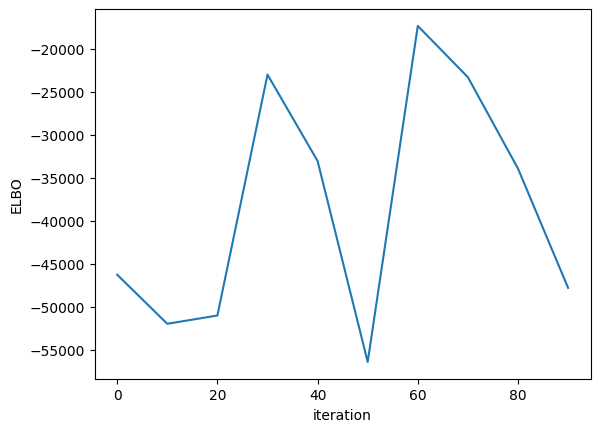

In [11]:
maxiter = reduce_in_tests(100)

logf = run_adam(model, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

## Performances after hyperparameter tuning

Below I plot the predicted values for the testing dataset against the expected (measured) values.

I don't do it for now for the training dataset, it takes too much time. Did it once, error is below 0.1, very good. We overfit a bit, which is not surprizing.

##########################
The train-valid RMSE is of 0.26
##########################


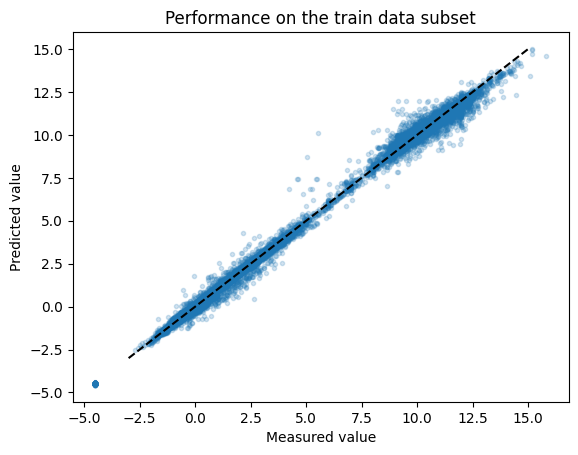

In [12]:
y_train_preds = model.predict_y(X_train_sc)
plt.plot(Y_train, y_train_preds[0],".", alpha=0.2)
plt.plot([-3,15],[-3,15],"k--")
plt.xlabel("Measured value")
plt.ylabel("Predicted value")
plt.title("Performance on the train data subset")

print("##########################")
print("The train-valid RMSE is of {:.2f}".format(root_mean_squared_error(Y_train, y_train_preds[0])))
print("##########################")

##########################
The test RMSE is of 0.34
##########################


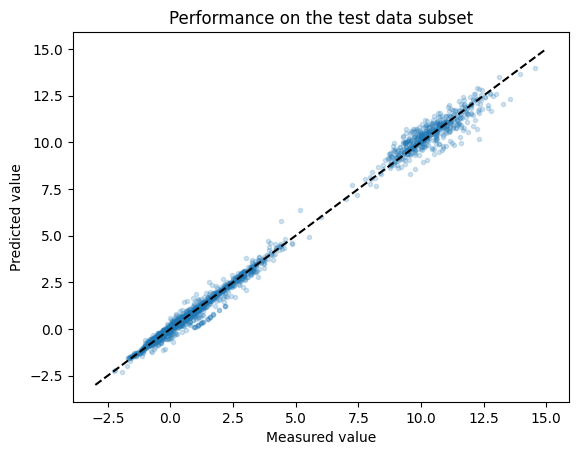

In [14]:
y_test_preds = model.predict_y(X_test_sc)
plt.plot(Y_test, y_test_preds[0],".", alpha=0.2)
plt.plot([-3,15],[-3,15],"k--")
plt.xlabel("Measured value")
plt.ylabel("Predicted value")
plt.title("Performance on the test data subset")

print("##########################")
print("The test RMSE is of {:.2f}".format(root_mean_squared_error(Y_test, y_test_preds[0])))
print("##########################")

## Saving the model

I now save the model after training. This is done using Tensorflow functions. We first need to provide a compiled version of the model...

In [15]:
model.compiled_predict_f = tf.function(
    lambda Xnew: model.predict_f(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, X_train_sc.shape[1]], dtype=tf.float64)],
)
model.compiled_predict_y = tf.function(
    lambda Xnew: model.predict_y(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, X_train_sc.shape[1]], dtype=tf.float64)],
)

save_dir = "./models/GP_Mater32_poly"
tf.saved_model.save(model, save_dir)


INFO:tensorflow:Assets written to: ./models/GP_Mater32_poly/assets


## Now we test predictions on two given data subsets.

We test to predict the viscosity of albite and peridotite melts.

We want to observe if extrapolation toward infinite temperatures tend to converge to a common limit, as people actually say.

We will use also the VFT equation with a high temperature limit at -4.5, we can compare this with results from GP.

In the figure below, we see that the blue curves tend toward -4.5.

The red ones do not.

Text(0, 0.5, 'Viscosity, log Pa s')

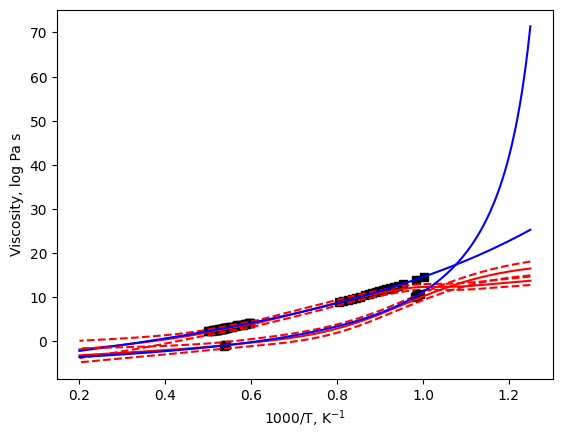

In [18]:
ab_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="NAK75_12_0")|
                     (ds.dataset_lp.Name_publi=="Ab"),:].reset_index()
pr_ = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Pr"),:].reset_index()

# our pressure and temperature ranges of interest
T_interest = np.arange(800,5000,2).reshape(-1,1)
P_interest = np.zeros(len(T_interest)).reshape(-1,1)

# get good values 
xi_ = ab_.loc[:, utils.list_oxides()].values
xi2_ = pr_.loc[:, utils.list_oxides()].values

# we make sure it is summing to 100
xi_ = (xi_/np.sum(xi_,axis=1).reshape(-1,1)).copy()
xi2_ = (xi2_/np.sum(xi2_,axis=1).reshape(-1,1)).copy()

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]
xi2 = np.ones((len(T_interest),xi2_.shape[1]))*xi2_[0,:]

# We get dataset usable with the GP now:
X_albite = np.concatenate((1000.0/T_interest.reshape(-1,1).copy(),
                           P_interest.reshape(-1,1).copy()/30.,
                           xi.copy()),axis=1)

X_peridotite = np.concatenate((1000.0/T_interest.reshape(-1,1).copy(),
                           P_interest.reshape(-1,1).copy()/30.,
                           xi2.copy()),axis=1)

# now we calculate the parameters for the VFT equations of the two melts
def VFT(x,B,C):
    return -4.5 + B/(x-C)

from scipy.optimize import curve_fit
pinit = [5000, 500]
popt_ab, pcov_ab = curve_fit(VFT, ab_["T"], ab_.viscosity,p0=pinit)
popt_peridotite, pcov_peridotite = curve_fit(VFT, pr_["T"], pr_.viscosity,p0=pinit)

#
# GP predictions
#
ab_predictive_mean, ab_predictive_var = model.predict_y(X_albite)
pr_predictive_mean, pr_predictive_var = model.predict_y(X_peridotite)

ab_predictive_std = np.sqrt(ab_predictive_var)
pr_predictive_std = np.sqrt(pr_predictive_var)

#
# And final figure !
#
plt.plot(1000/ab_["T"], ab_["viscosity"],"ks", label="data Ab")
plt.plot(1000/T_interest, ab_predictive_mean,"r-")
plt.plot(1000/T_interest, ab_predictive_mean-1.96*ab_predictive_std,"r--")
plt.plot(1000/T_interest, ab_predictive_mean+1.96*ab_predictive_std,"r--")
plt.plot(1000/T_interest, VFT(T_interest, *popt_ab),"b-", label="VFT Ab")

plt.plot(1000/pr_["T"], pr_["viscosity"],"ks",label="data Pr")
plt.plot(1000/T_interest, pr_predictive_mean,"r-")
plt.plot(1000/T_interest, pr_predictive_mean-1.96*pr_predictive_std,"r--")
plt.plot(1000/T_interest, pr_predictive_mean+1.96*pr_predictive_std,"r--")
plt.plot(1000/T_interest, VFT(T_interest, *popt_peridotite),"b-", label="VFT Pr")

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")

# Pressure effect

The following below will not work straight out of the box for now

I need to modify it again.

This is because I don't scale the data anymore with a scikit-learn scaler.

In [11]:
###
# Peridotite
###
dataset_peridotite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="peridotite",:].reset_index()
# add descriptors
xi_ = utils.descriptors(dataset_peridotite.loc[:, utils.list_oxides()]/100).values

ptxi_peridotite = ds.scale_for_gaussianprocess(dataset_peridotite["T"].values, 
                               dataset_peridotite["P"].values,xi_)

peridotite_predictive_mean, peridotite_predictive_var = model.predict_y(ptxi_peridotite)
peridotite_predictive_std = np.sqrt(peridotite_predictive_var)

In [12]:

###
# CaSiO3
###
dataset_casio3 = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="casio3",:].reset_index()
# add descriptors
xi_ = utils.descriptors(dataset_casio3.loc[:, utils.list_oxides()]/100).values

# transformation
ptxi_casio3 = ds.scale_for_gaussianprocess( 
                               dataset_casio3["T"].values, 
                               dataset_casio3["P"].values,xi_)

casio3_predictive_mean, casio3_predictive_var = model.predict_y(ptxi_casio3)
casio3_predictive_std = np.sqrt(casio3_predictive_var)

###
# Albite
###
dataset_albite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()
# add descriptors
xi_ = utils.descriptors(dataset_albite.loc[:, utils.list_oxides()]/100).values

# transformation
ptxi_albite = ds.scale_for_gaussianprocess( 
                               dataset_albite["T"].values, 
                               dataset_albite["P"].values,xi_)

albite_predictive_mean, albite_predictive_var = model.predict_y(ptxi_albite)
albite_predictive_std = np.sqrt(albite_predictive_var)

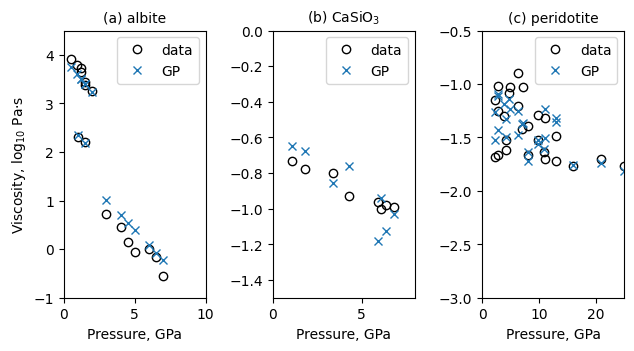

In [13]:
plt.figure(figsize=(6.44,6.44))
plt.subplot(2,3,1)
plt.title("(a) albite", fontsize=10)
plt.plot(dataset_albite.loc[:,"P"],dataset_albite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_albite.loc[:,"P"],
         albite_predictive_mean,"x", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
plt.ylim(-1,4.5)
plt.xlim(0,10)
plt.legend()

plt.subplot(2,3,2)
plt.title("(b) CaSiO$_3$", fontsize=10)
plt.plot(dataset_casio3.loc[:,"P"],dataset_casio3.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_casio3.loc[:,"P"],
         casio3_predictive_mean,"x", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-1.5,0)
plt.xlim(0,8)
plt.legend()

plt.subplot(2,3,3)
plt.title("(c) peridotite", fontsize=10)
plt.plot(dataset_peridotite.loc[:,"P"],dataset_peridotite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_peridotite.loc[:,"P"],
         peridotite_predictive_mean,"x", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-3.0,-0.5)
plt.xlim(0,25)
plt.legend()

plt.tight_layout()

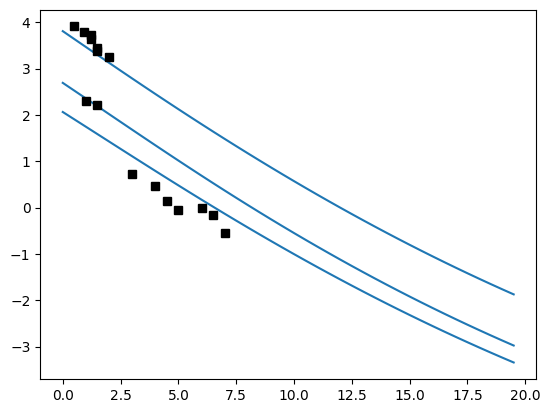

In [14]:
P_interest = np.arange(0,20.,0.5)

# add descriptors
xi_ = utils.descriptors(dataset_albite.loc[:, utils.list_oxides()]/100).values

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(P_interest),xi_.shape[1]))*xi_[0,:]

# Albite dataset
for i in [1873, 1673, 2000]:
    T_interest = i*np.ones(len(P_interest))

    # transformation
    ptxi_scaled = ds.scale_for_gaussianprocess( 
                                   T_interest.reshape(-1,1), 
                                   P_interest.reshape(-1,1),xi)
    predictive_mean, predictive_var = model.predict_y(ptxi_scaled)
    predictive_std = np.sqrt(predictive_var)

    plt.plot(P_interest, predictive_mean,color="C0",linestyle="-")
    #plt.plot(P_interest, predictive_mean*10+predictive_std*10,color="C0",linestyle="--")
    #plt.plot(P_interest, predictive_mean*10-predictive_std*10,color="C0",linestyle="--")

plt.plot(dataset_albite["P"], dataset_albite["viscosity"], "ks")
